In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [2]:
raw_df = pd.read_csv('data/zillow_data.csv')
raw_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


Filter only for Texas
<br>Drop Metro because there were many nulls, and it was redundant with other location data 
<br> Drop regionID and SizeRank because values were specific to Zillow 

In [3]:
raw_df = raw_df[raw_df['State']=='TX']
raw_df.drop(raw_df.columns[np.r_[0,3,4, 6]], axis=1, inplace=True)
raw_df = raw_df.rename(columns={'RegionName': 'zipcode'})


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
#Calculate historical return on investment
raw_df['ROI']= (raw_df['2018-04']/raw_df['2004-01'])-1
raw_df['ROI']


#Calculate standard deviation of monthly values
raw_df['std']=raw_df.loc[:,'2004-01':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
raw_df['mean']=raw_df.loc[:,'2004-01':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
raw_df['CV']=raw_df['std']/raw_df['mean']

#Show calculated values
raw_df[['zipcode','std','mean','ROI','CV']].head()



,zipcode,std,mean,ROI,CV
1,75070,38257.775512,227040.116279,0.714438,0.168507
2,77494,33208.367605,266633.139535,0.423210,0.124547
4,79936,10248.462666,113729.651163,0.446429,0.090112
5,77084,14170.210695,130143.604651,0.376047,0.108881
8,77449,16508.811448,134945.348837,0.422115,0.122337


In [5]:
def melt_data(raw_df):
    melted = pd.melt(raw_df, id_vars=['zipcode', 'City', 'CountyName','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [6]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   zipcode     255096 non-null  int64         
 1   City        255096 non-null  object        
 2   CountyName  255096 non-null  object        
 3   ROI         250688 non-null  float64       
 4   std         255096 non-null  float64       
 5   mean        255096 non-null  float64       
 6   CV          255096 non-null  float64       
 7   date        255096 non-null  datetime64[ns]
 8   value       255096 non-null  float64       
 9   year        255096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 21.4+ MB


In [7]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.714438,38257.775512,227040.116279,0.168507,235700.0,1996
1996-04-01,77494,Katy,Harris,0.423210,33208.367605,266633.139535,0.124547,210400.0,1996
1996-04-01,79936,El Paso,El Paso,0.446429,10248.462666,113729.651163,0.090112,77300.0,1996
1996-04-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,95000.0,1996
1996-04-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,95400.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [8]:
df_income = pd.read_csv('data/zip_codes_2019_median_inc.csv')
df_income['state'] = df_income['Preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['Type'] != 'PO box'])
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 31142 to 34261
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ZIP Code                     1839 non-null   int64  
 1   Type                         1839 non-null   object 
 2   State FIPS                   1839 non-null   int64  
 3   Preferred name               1839 non-null   object 
 4   Alternate names              829 non-null    object 
 5   Population (2019)            1718 non-null   object 
 6   Housing units (2019)         1718 non-null   object 
 7   Median family income (2019)  1623 non-null   object 
 8   MFI percentile (2019)        1623 non-null   float64
 9   Latitude                     1718 non-null   float64
 10  Longitude                    1718 non-null   float64
 11  Land area                    1718 non-null   float64
 12  Water area                   1718 non-null   float64
 13  state        

In [9]:
df_income.drop(df_income.columns[np.r_[1:5,6,8,11,12]], axis=1, inplace=True)
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 31142 to 34261
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ZIP Code                     1839 non-null   int64  
 1   Population (2019)            1718 non-null   object 
 2   Median family income (2019)  1623 non-null   object 
 3   Latitude                     1718 non-null   float64
 4   Longitude                    1718 non-null   float64
 5   state                        1839 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 100.6+ KB


Clean up column names

In [10]:
df_income = df_income.rename(columns={'Median family income (2019)': 'median_family_income',
                               'Population (2019)': 'population',
                               'ZIP Code': 'zipcode'})

In [11]:
df_income['median_family_income']

31142         NaN
31143         NaN
31744     $79,551
31745    $105,656
31746     $72,325
           ...   
34257         NaN
34258         NaN
34259         NaN
34260         NaN
34261         NaN
Name: median_family_income, Length: 1839, dtype: object

In [12]:
df_income['median_family_income'] = df_income['median_family_income'].str.strip('$\n\t')
df_income['median_family_income'] = df_income['median_family_income'].str.replace(',','')
df_income  = df_income[df_income['median_family_income'].notna()]
df_income['median_family_income'] = df_income['median_family_income'].astype(int)



 

In [13]:
df_income

,zipcode,population,median_family_income,Latitude,Longitude,state
31744,75001,"14,992",79551,32.959999,-96.838997,TX
31745,75002,"71,253",105656,33.090000,-96.609001,TX
31746,75006,"51,642",72325,32.962002,-96.899002,TX
31747,75007,"55,500",96094,33.005001,-96.897003,TX
31748,75009,"14,089",117857,33.339001,-96.752998,TX
...,...,...,...,...,...,...
34233,79932,"28,243",75676,31.875000,-106.608002,TX
34234,79934,"26,445",71037,31.951000,-106.433998,TX
34235,79935,"17,850",61607,31.768000,-106.329002,TX
34236,79936,"111,620",61016,31.777000,-106.296997,TX


In [14]:
df_income['population'] = df_income['population'].str.replace(',','')
df_income = df_income[df_income['population'].notna()]
df_income['population'] = df_income['population'].astype(int)

In [15]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               1623 non-null   int64  
 1   population            1623 non-null   int64  
 2   median_family_income  1623 non-null   int64  
 3   Latitude              1623 non-null   float64
 4   Longitude             1623 non-null   float64
 5   state                 1623 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 88.8+ KB


In [16]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               1623 non-null   int64  
 1   population            1623 non-null   int64  
 2   median_family_income  1623 non-null   int64  
 3   Latitude              1623 non-null   float64
 4   Longitude             1623 non-null   float64
 5   state                 1623 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 88.8+ KB


In [17]:
df_merged = df.reset_index().merge(df_income, how="left").set_index('date')


In [18]:
df_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,255096.0,77163.777546,1361.342308,75001.000000,76017.000000,77098.000000,78251.000000,7.993800e+04
ROI,250688.0,0.555045,0.220161,-0.301587,0.433762,0.568088,0.690932,1.492424e+00
std,255096.0,19293.447963,14721.703670,1461.036168,9722.379916,15323.179456,24310.266169,1.144473e+05
mean,255096.0,152345.931372,101343.908780,32718.292683,89145.930233,125308.139535,179249.418605,9.569622e+05
CV,255096.0,0.121714,0.036146,0.019827,0.098849,0.121427,0.142339,2.930644e-01
value,255096.0,140540.600793,99061.016727,24100.000000,79900.000000,113700.000000,165100.000000,1.268600e+06
year,255096.0,2006.908003,6.393508,1996.000000,2001.000000,2007.000000,2012.000000,2.018000e+03
population,252181.0,25939.370892,20385.536014,1056.000000,9761.000000,21879.000000,37281.000000,1.282940e+05
median_family_income,252181.0,77689.448301,32642.262099,21169.000000,56108.000000,69722.000000,90867.000000,2.500010e+05
Latitude,252181.0,31.108154,1.797547,25.944000,29.736000,30.805000,32.723999,3.604600e+01


# Filtering

Get IQR of data based on salaries  

In [19]:
# Select the first quantile
q1 = df_merged['value'].quantile(.25)

# Select the third quantile
q3 = df_merged['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered =df_merged[(df_merged['value']>=q1) 
             & (df_merged['value']<=q3)]
df_merged = pd.DataFrame(filtered)
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state
date,,,,,,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,95000.0,1996,107673.0,70460.0,29.827000,-95.660004,TX
1996-04-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,TX
1996-04-01,78660,Pflugerville,Travis,0.578674,23031.089035,180093.023256,0.127884,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,TX
1996-04-01,77573,League City,Galveston,0.568086,23867.673325,199441.279070,0.119673,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,TX
1996-04-01,77584,Pearland,Brazoria,0.433762,21811.667986,202840.697674,0.107531,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018,1871.0,78438.0,35.007000,-101.393997,TX
2018-04-01,77577,Liverpool,Brazoria,0.761511,17597.138719,108870.348837,0.161634,149200.0,2018,1481.0,76382.0,29.284000,-95.281998,TX
2018-04-01,77663,Kountze,Hardin,0.312721,11184.253614,131325.581395,0.085164,148600.0,2018,NaN,NaN,NaN,NaN,NaN


**Create Affordability Score**

In [20]:
df_merged['median_house_price'] = df_merged.groupby('date').aggregate({'value':'median'})
 

In [21]:
df_merged['affordability'] = df_merged['value'] -df_merged['median_family_income']/.12

In [22]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
df_merged['affordability_score']  = normalize_data(df_merged['affordability'])
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,95000.0,1996,107673.0,70460.0,29.827000,-95.660004,TX,106600.0,-492166.666667,0.591511
1996-04-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,TX,106600.0,-593900.000000,0.484277
1996-04-01,78660,Pflugerville,Travis,0.578674,23031.089035,180093.023256,0.127884,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,TX,106600.0,-692208.333333,0.380652
1996-04-01,77573,League City,Galveston,0.568086,23867.673325,199441.279070,0.119673,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,TX,106600.0,-874791.666667,0.188196
1996-04-01,77584,Pearland,Brazoria,0.433762,21811.667986,202840.697674,0.107531,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,TX,106600.0,-912691.666667,0.148247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018,1871.0,78438.0,35.007000,-101.393997,TX,123500.0,-569250.000000,0.510260
2018-04-01,77577,Liverpool,Brazoria,0.761511,17597.138719,108870.348837,0.161634,149200.0,2018,1481.0,76382.0,29.284000,-95.281998,TX,123500.0,-487316.666667,0.596623
2018-04-01,77663,Kountze,Hardin,0.312721,11184.253614,131325.581395,0.085164,148600.0,2018,NaN,NaN,NaN,NaN,NaN,123500.0,NaN,NaN


In [23]:
top_20 = df_merged['affordability_score'].quantile(.2)
df_merged_20 = df_merged[(df_merged['affordability_score'] <top_20)] 
df_merged_20 = df_merged['2017-01-01':].dropna()
df_merged_20.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6685 entries, 2017-01-01 to 2018-04-01
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               6685 non-null   int64  
 1   City                  6685 non-null   object 
 2   CountyName            6685 non-null   object 
 3   ROI                   6685 non-null   float64
 4   std                   6685 non-null   float64
 5   mean                  6685 non-null   float64
 6   CV                    6685 non-null   float64
 7   value                 6685 non-null   float64
 8   year                  6685 non-null   int64  
 9   population            6685 non-null   float64
 10  median_family_income  6685 non-null   float64
 11  Latitude              6685 non-null   float64
 12  Longitude             6685 non-null   float64
 13  state                 6685 non-null   object 
 14  median_house_price    6685 non-null   float64
 15  aff

In [24]:
#Descriptive statistics of coefficients of variance.
print(df_merged_20.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df_merged_20.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
df_20_cv = df_merged_20[df_merged_20['CV']<upper_cv] 


count    6685.000000
mean        0.114755
std         0.035013
min         0.033372
25%         0.090004
50%         0.113610
75%         0.135465
max         0.260753
Name: CV, dtype: float64

CV upper limit: 0.12188571953567728


In [32]:
df_20_cv.loc[df_20_cv.groupby("zipcode")["ROI"].idxmax()]


,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2017-01-01,79936,El Paso,El Paso,0.446429,10248.462666,113729.651163,0.090112,116900.0,2017,111620.0,61016.0,31.777000,-106.296997,TX,120400.0,-391566.666667,0.697551
2017-01-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,156500.0,2017,107673.0,70460.0,29.827000,-95.660004,TX,120400.0,-430666.666667,0.656337
2017-01-01,78572,Mission,Hidalgo,0.308564,5572.503793,86597.093023,0.064350,95100.0,2017,80601.0,49642.0,26.229000,-98.375000,TX,120400.0,-318583.333333,0.774481
2017-01-01,78245,San Antonio,Bexar,0.591082,12531.814254,132088.953488,0.094874,152600.0,2017,76518.0,74364.0,29.400999,-98.731003,TX,120400.0,-467100.000000,0.617933
2017-01-01,79938,El Paso,El Paso,0.416259,8901.334504,136026.162791,0.065438,142600.0,2017,84237.0,62111.0,31.830000,-105.971001,TX,120400.0,-374991.666667,0.715022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,77335,Goodrich,Polk,0.624629,9722.379916,84579.651163,0.114949,99900.0,2017,2972.0,62770.0,30.573999,-94.911003,TX,120400.0,-423183.333333,0.664225
2017-01-01,76093,Rio Vista,Johnson,0.618421,11815.006236,106067.441860,0.111391,130100.0,2017,1792.0,64125.0,32.209999,-97.392998,TX,120400.0,-404275.000000,0.684156
2017-01-01,78393,Woodsboro,Refugio,0.262579,6087.459603,69540.697674,0.087538,80000.0,2017,2161.0,56818.0,28.187000,-97.382004,TX,120400.0,-393483.333333,0.695531


# EDA

Create DataFrame to perform stationarity checks and transformations

In [26]:
df_prices = pd.DataFrame(df['value'], index = df.index)
df_prices

,value
date,
1996-04-01,235700.0
1996-04-01,210400.0
1996-04-01,77300.0
1996-04-01,95000.0
1996-04-01,95400.0
...,...
2018-04-01,121600.0
2018-04-01,63300.0
2018-04-01,93500.0


**Mean prices by year**

<AxesSubplot:xlabel='date'>

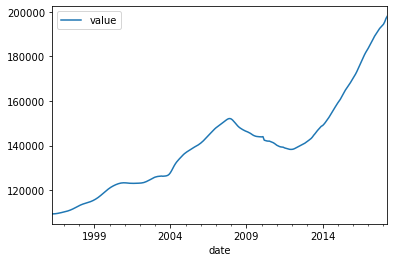

In [27]:
avg_prices = df_prices.groupby('date').aggregate({'value':'mean'})
avg_prices.plot()

<AxesSubplot:xlabel='date'>

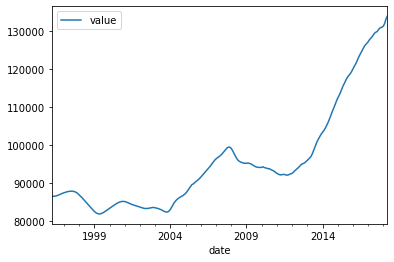

In [28]:
std_prices = df_prices.groupby('date').aggregate({'value':'std'})
std_prices.plot()

<AxesSubplot:xlabel='date'>

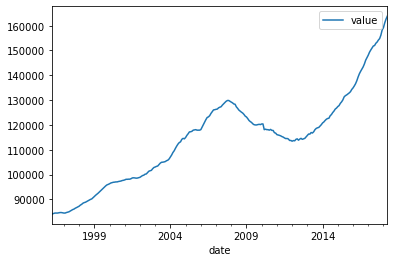

In [29]:
med_prices = df_prices.groupby('date').aggregate({'value':'median'})
med_prices.plot()

In [30]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

In [31]:
results = stationarity_check(df_prices)
results

KeyboardInterrupt: 

**Log Transformations**

In [ ]:
df_log = np.log(df_prices)
fig = plt.figure(figsize=(15,8))
plt.plot(df_log, color='blue');


**Weighted Rolling Mean**

In [ ]:
weight_roll_mean = df_log.ewm(halflife=4).mean()
df_log_wrm = df_log - weight_roll_mean
df_log_wrm.plot(figsize=(15,8))



In [ ]:
type(df_log_wrm.index)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(df_log_wrm, order=(1, 0, 0))
res = mod.fit()
print(res.summary())